In [1]:
# Cell 1: Install Dependencies
!pip install simpy geopandas shapely geopy pandas matplotlib folium

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
     ------- -------------------------------- 10.2/51.5 kB ? eta -:--:--
     -------------------------------------- 51.5/51.5 kB 878.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------- -------------------------------- 0.2/1.1 MB 4.1 MB/s eta 0:00:01
   ------------------------ --------------- 0.7/1.1 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------------------------ --------------- 0.9/1.4 MB 27.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 23.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ---------------------------------------- 125.4/125.4 kB 7.7 MB/s eta 0:00:00
   -----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# Cell 2: Import Libraries
import simpy
import geopandas as gpd
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import pandas as pd
import matplotlib.pyplot as plt
import folium


Matplotlib is building the font cache; this may take a moment.


In [2]:
# Cell 3: Define Toll Zones and Road Network
# Define toll zones as geospatial coordinates (example)
toll_zones = gpd.GeoDataFrame({
    'geometry': [Point(12.9716, 77.5946), Point(13.0827, 80.2707)]  # Example coordinates
}, crs="EPSG:4326")

# Define road network (example)
road_network = gpd.GeoDataFrame({
    'geometry': [LineString([(12.9716, 77.5946), (13.0827, 80.2707)])]
}, crs="EPSG:4326")



In [3]:
# Cell 4: Initialize Vehicle Data and Display Output
vehicles = pd.DataFrame({
    'id': [1, 2],  # Vehicle IDs
    'start': [(12.9716, 77.5946), (12.2958, 76.6394)],  # Start locations
    'end': [(13.0827, 80.2707), (12.9716, 77.5946)],  # End locations
    'balance': [1000, 800]  # Account balances
})

# Display Vehicle Data
vehicles

,id,start,end,balance
0,1,"(12.9716, 77.5946)","(13.0827, 80.2707)",1000
1,2,"(12.2958, 76.6394)","(12.9716, 77.5946)",800


In [4]:
# Cell 5: Define Vehicle Movement and Toll Calculation Functions
def vehicle_movement(env, vehicle_id, start, end, toll_zones, road_network):
    current_position = start
    while current_position != end:
        # Move vehicle towards end point (simplified for example purposes)
        current_position = end
        
        # Detect if vehicle enters toll zones
        for _, zone in toll_zones.iterrows():
            if Point(current_position).within(zone['geometry']):
                print(f"Vehicle {vehicle_id} entered toll zone at {env.now}")
                env.process(calculate_toll(env, vehicle_id))
        yield env.timeout(1)  # Simulate time passing

def calculate_toll(env, vehicle_id):
    toll_rate = 5  # Example toll rate
    vehicles.loc[vehicles['id'] == vehicle_id, 'balance'] -= toll_rate
    print(f"Toll deducted for vehicle {vehicle_id} at {env.now}")
    yield env.timeout(0)  # Yield to make this a generator

In [5]:
# Cell 6: Setup and Run Simulation Environment
# Initialize simulation environment
env = simpy.Environment()

# Add vehicles to simulation
for _, vehicle in vehicles.iterrows():
    env.process(vehicle_movement(env, vehicle['id'], vehicle['start'], vehicle['end'], toll_zones, road_network))

# Run simulation
env.run(until=10)

Vehicle 1 entered toll zone at 0
Vehicle 2 entered toll zone at 0
Toll deducted for vehicle 1 at 0
Toll deducted for vehicle 2 at 0


   id               start                 end  balance
0   1  (12.9716, 77.5946)  (13.0827, 80.2707)      995
1   2  (12.2958, 76.6394)  (12.9716, 77.5946)      795


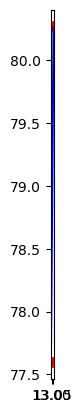

In [6]:
# Cell 7: Display Vehicle Data and Visualization
# Generate report
print(vehicles)

# Visualization of toll zones and road network
base = toll_zones.plot(color='red', markersize=50)
road_network.plot(ax=base, color='blue')
plt.show()

In [7]:
# Cell 8: Map Visualization with Folium
# Folium map
m = folium.Map(location=[12.9716, 77.5946], zoom_start=10)
for _, row in toll_zones.iterrows():
    folium.Marker([row['geometry'].y, row['geometry'].x], popup='Toll Zone').add_to(m)
m.save('toll_system_map.html')
m